<a href="https://colab.research.google.com/github/abhijiths1998/Zshoes_Case-Study/blob/main/Case_Study_Zshoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective:

Predicting shoes price for the customers of Zshoes and deploy with the help of flask.

## Problem Statement:

Zshoes.com is one of the famous shoe manufacturers of India and has business in
almost every country in Asia and Europe. They are one of the best choices of all the
athletics and they make the best shoes for running. Due to pandemic, they are facing a
loss as Zshoes are a bit expensive. They want to know the correct price of all types of
shoes that they are manufacturing so that they won’t face any loss and at the same
time customers also buy the shoes. As a machine learning engineer, we have to build a
shoe-price prediction app that can predict the correct shoe price by taking inputs like
freight_value,payment_type, etc.

### Importing Libraries

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

### Data Understanding

In [108]:
df = pd.read_csv('product_data.csv')

In [109]:
# Getting the first few data points
df.head()

,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,1,58.90,13.29,1,1,2,72.19
1,1,239.90,19.93,1,1,3,259.83
2,1,199.00,17.87,1,1,5,216.87
3,1,12.99,12.79,1,1,2,25.78
4,1,199.90,18.14,1,1,3,218.04


In [110]:
# Price is the target column (y) rest are the independent variables

In [111]:
# Getting the shape of the data
df.shape

(101335, 7)

In [112]:
# Getting basic data information 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101335 entries, 0 to 101334
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_item_id         101335 non-null  int64  
 1   price                 101335 non-null  float64
 2   freight_value         101335 non-null  float64
 3   payment_sequential    101335 non-null  int64  
 4   payment_type          101335 non-null  int64  
 5   payment_installments  101335 non-null  int64  
 6   payment_value         101335 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 5.4 MB


In [113]:
# Five point summary of the data
df.describe()

,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
count,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000,101335.000000
mean,1.205280,79.818332,16.126716,1.089495,1.352040,2.671703,124.124508
std,0.715244,56.057932,5.943237,0.689100,0.652362,2.524321,124.418064
min,1.000000,0.850000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,35.990000,12.690000,1.000000,1.000000,1.000000,55.550000
50%,1.000000,63.900000,15.470000,1.000000,1.000000,1.000000,95.400000
75%,1.000000,109.900000,18.670000,1.000000,2.000000,3.000000,155.840000
max,21.000000,270.000000,36.000000,26.000000,4.000000,24.000000,3195.730000


In [114]:
df[df['freight_value'] == 0]['payment_sequential'].value_counts()

1    382
2      3
3      1
4      1
5      1
6      1
Name: payment_sequential, dtype: int64

In [115]:
### Some Insights
# The minimum payment value is 0 which is rare though it is possible
# Also we can see there are no null values in the data
# Payment installments starts from 0 which can mean 1 time payment 
# When freight is 0 , payment sequence gets down to 1 in most cases

### EDA

In [116]:
# As we mentioned above there is no null values in the data. Hence no need to check for it

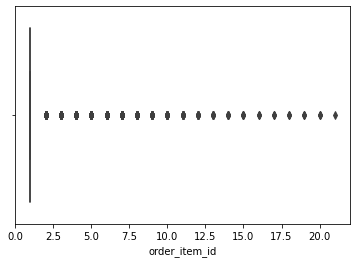

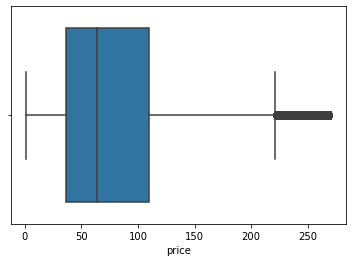

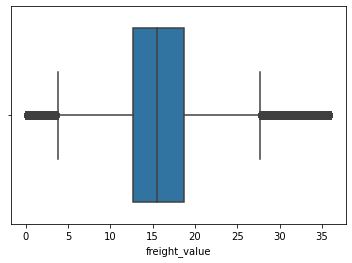

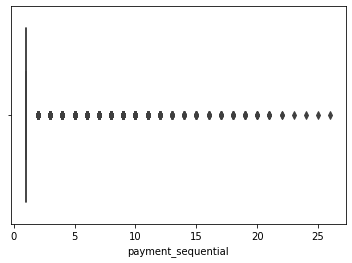

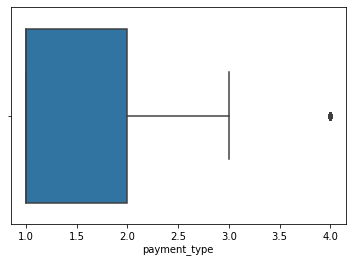

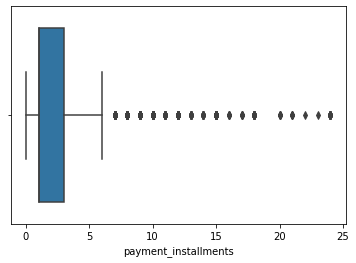

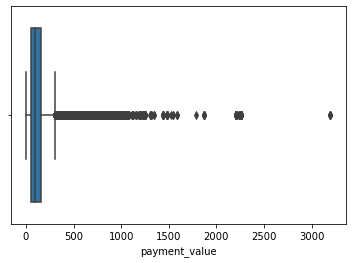

In [117]:
# Checking for outliers

for i in df.columns:
  sns.boxplot(df[i])
  plt.show()

In [118]:
df.columns

Index(['order_item_id', 'price', 'freight_value', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'],
      dtype='object')

In [119]:
# We can clearly see there are outliers. So we are moving forward with treating outliers
num_cols = df[['price','payment_installments','freight_value','payment_value']]
for col in num_cols.columns:
  q1 = num_cols[col].quantile(0.25)
  q3 = num_cols[col].quantile(0.75)
  iqr = q3-q1
  ll = q1 - (1.5*iqr)
  ul = q3 + (1.5*iqr)
  for ind in df[col].index:
    if df.loc[ind,col] < ll :
      df.loc[ind,col] = ll
    elif df.loc[ind,col] > ul :
      df.loc[ind,col] = ul


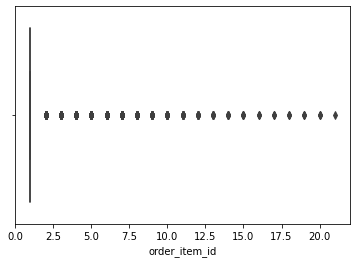

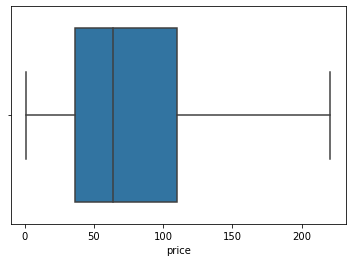

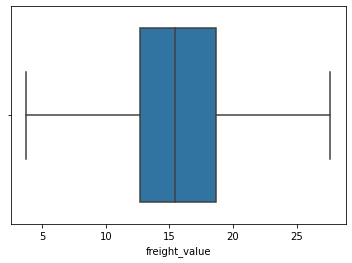

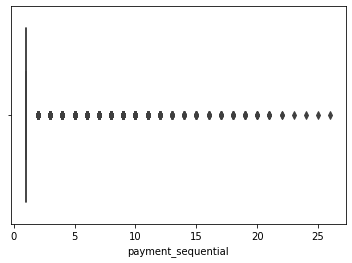

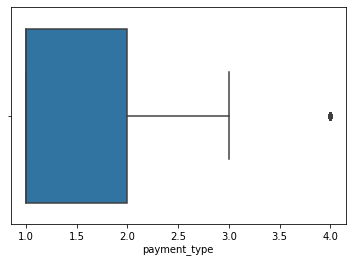

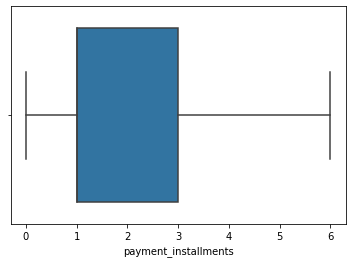

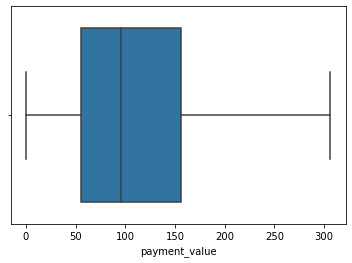

In [120]:
# Boxplot after outlier treatment
for i in df.columns:
  sns.boxplot(df[i])
  plt.show()

In [121]:
# Outliers has been treated

<AxesSubplot:xlabel='payment_type'>

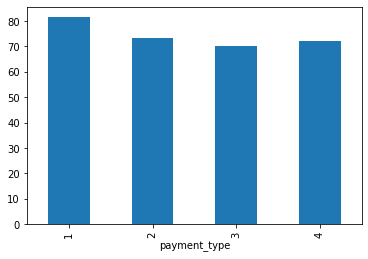

In [122]:
# Average price for each payment type
df.groupby('payment_type')['price'].mean().plot(kind='bar')

In [123]:
# Most payment is coming from payment type 1 gateway

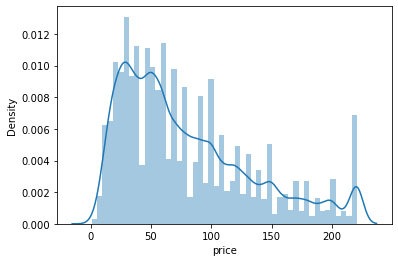

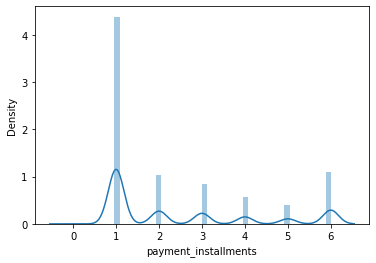

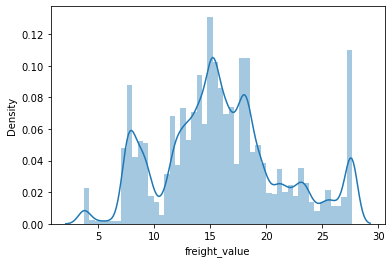

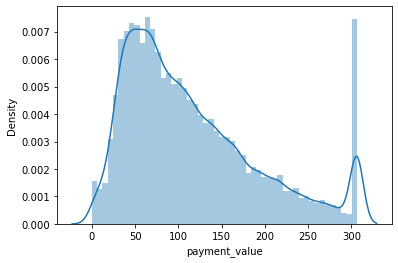

In [124]:
# Checking for skewness with distribution plot
for i in num_cols:
  sns.distplot(df[i])
  plt.show()

In [125]:
# Freight has a good distribution shape whereas payment value is slightly right skewed

<AxesSubplot:xlabel='order_item_id'>

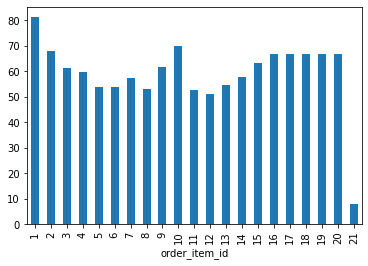

In [126]:
# Order id wise price distribution
df.groupby('order_item_id')['price'].mean().plot(kind = 'bar')

In [127]:
# Average order item id 1 is the highest

### Model Building and Evaluation

In [128]:
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson as db
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,StackingRegressor,VotingRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import scipy.stats as stats

#### Splitting data into x and y

In [129]:
df = df.drop(columns = ['order_item_id'])

In [130]:
x = df.drop(columns=['price'])
y = df['price']

#### Assumptions prior to building a linear model

<AxesSubplot:>

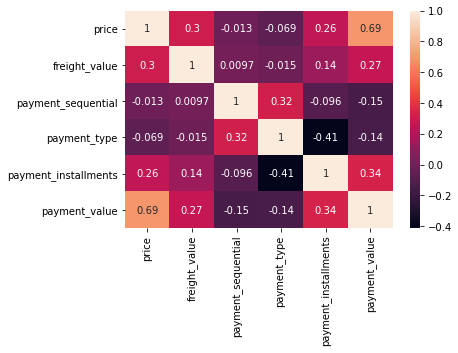

In [131]:
# Checking the relationship between target and independent variables
sns.heatmap(df.corr(),annot=True)

In [132]:
# Apart from payment value, none of the variables have correlation with the target variable which is price

In [133]:
# Normality of the target (As the data points are above 5000 we just take a random sample of 1000 
# inorder to validate the normality)
# Ho : data is normal
# Ha : data is not normal

# hypothesis testing function
def hyp_testing(pval,sig_lvl):
  if pval>sig_lvl:
    return 'Fail to reject Ho'
  else:
    return 'Ho rejected'

sh = y.sample(1000,random_state = 7)
w,pval = stats.shapiro(sh)
print(pval)
print(hyp_testing(pval,0.05))

2.048851039499679e-24
Ho rejected


In [134]:
# Target variable is not normal

In [135]:
# Multi-Collinearity
vif = pd.DataFrame()
vif['Factor'] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
vif['Features'] = df.columns
vif.sort_values(by = 'Factor',ascending=False)

,Factor,Features
1,7.501890,freight_value
5,6.746151,payment_value
0,6.301341,price
3,5.062311,payment_type
2,3.836369,payment_sequential
4,3.130878,payment_installments


In [136]:
## Multicollinearity is at an acceptable level(eventhough above 5 but still highest factor below 10)

#### Train Test Split

In [137]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=7)

#### Model Building

In [138]:
# Base model LinearRegression
lr = LinearRegression()
base = lr.fit(xtrain,ytrain)
ypred = base.predict(xtest)

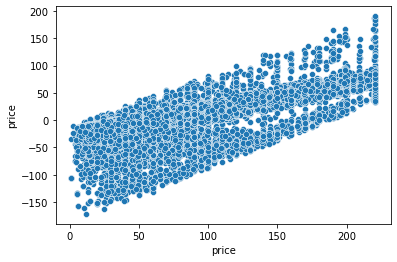

In [139]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [140]:
#Finding r2, mse and rmse using cross validation
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=lr,X=x,y=y,scoring = 'r2',cv=kf)
r2_lr = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_lr = 1 - ((1-r2_lr)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=lr,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_lr = np.abs(np.mean(mse))
rmse_lr = np.sqrt(mse_lr)
print(r2_lr)
print(adj_r2_lr)
print(rmse_lr) 

0.5042723672590249
0.5042479059679463
38.281840636905926


In [141]:
# Not good results because only around 50% of the variance can be explained by the model. 
# So we are going forward with feature selection

In [142]:
r = ytest-ypred
db(r,axis=0)

2.010932751934271

In [143]:
# Durbin-Watson is around 2, hence there is no auto-correlation

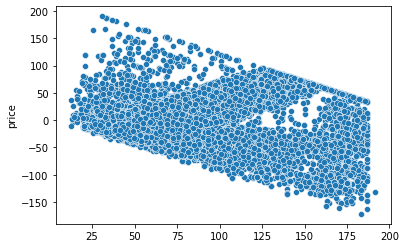

In [144]:
# Checking for Heteroscedasticity(residual vs fitted plot)
r = ytest-ypred
sns.scatterplot(x = ypred, y = r)
plt.show()

In [145]:
# It is clearly not showing a funnel shaped distribution which means the data is homoskedastic

In [179]:
# As the data is not satisfying normality and the overall performance of the model is not good, 
# I can't move forward with linear models

In [147]:
#2nd model - DecisionTreeRegressor
dt = DecisionTreeRegressor()
model_v1 = dt.fit(xtrain,ytrain)
ypred =  model_v1.predict(xtest)

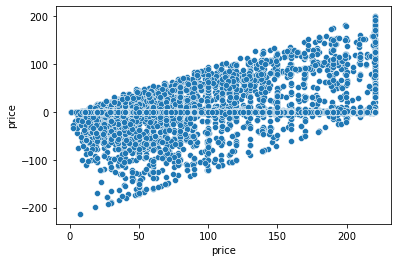

In [148]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [149]:
#Finding r2, mse and rmse using cross validation
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=dt,X=x,y=y,scoring = 'r2',cv=kf)
r2_dt = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_dt = 1 - ((1-r2_dt)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=dt,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_dt = np.abs(np.mean(mse))
rmse_dt = np.sqrt(mse_dt)
print(r2_dt)
print(adj_r2_dt)
print(rmse_dt) 

0.7705412852030891
0.7705299627428459
37.142450196396354


In [150]:
# The results are much better now , we can do feature selection on the data using this model
sf = sfs(dt,k_features=2,scoring = 'neg_mean_squared_error',cv=k)
feat = sf.fit(x,y)

In [151]:
feat.k_feature_names_

('freight_value', 'payment_value')

In [152]:
#These are the most important features,let's build a model based on this features
new_feat = x[['freight_value','payment_value']]

#Finding r2, mse and rmse using cross validation on new features
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=dt,X=new_feat,y=y,scoring = 'r2',cv=kf)
r2_dt = np.mean(r2)
n = new_feat.shape[0]
k = new_feat.shape[1]
adj_r2_dt = 1 - ((1-r2_dt)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=dt,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_dt = np.abs(np.mean(mse))
rmse_dt = np.sqrt(mse_dt)
print(r2_dt)
print(adj_r2_dt)
print(rmse_dt) 

0.7884479641845006
0.7884437887604329
38.54726313840648


In [153]:
# feature selection didn't do much improvement

In [154]:
# Model3 - RandomForest
rf = RandomForestRegressor()
model_v2 = rf.fit(xtrain,ytrain)
ypred =  model_v2.predict(xtest)

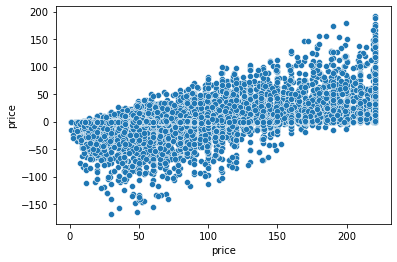

In [155]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [156]:
#Finding r2, mse and rmse using cross validation
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=rf,X=x,y=y,scoring = 'r2',cv=kf)
r2_rf = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_rf = 1 - ((1-r2_rf)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=rf,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_rf = np.abs(np.mean(mse))
rmse_rf = np.sqrt(mse_rf)
print(r2_rf)
print(adj_r2_rf)
print(rmse_rf) 

0.8469298542223529
0.8469223010961118
30.471358785192837


In [157]:
# This is more improved comparing to decision tree

In [158]:
# Model4 - AdaBoostRegressor
ada = AdaBoostRegressor()
model_v3 = rf.fit(xtrain,ytrain)
ypred =  model_v3.predict(xtest)

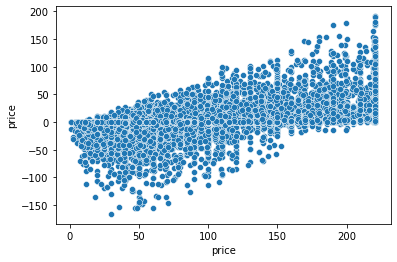

In [159]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [160]:
#Finding r2, mse and rmse using cross validation
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=ada,X=x,y=y,scoring = 'r2',cv=kf)
r2_ada = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_ada = 1 - ((1-r2_ada)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=ada,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_ada = np.abs(np.mean(mse))
rmse_ada = np.sqrt(mse_ada)
print(r2_ada)
print(adj_r2_ada)
print(rmse_ada) 

0.5216052930785906
0.5215816870671368
37.024634914107686


In [161]:
# As expected , boosting using decision stumps gave a bad result comparing to random forest and decision trees
# This should be fixed with another popular boosting algorithm XGBoost

In [162]:
# Model 5 - XGBoostRegressor

xgb = XGBRegressor(verbosity=0)
model_v4 = xgb.fit(xtrain,ytrain)
ypred =  model_v4.predict(xtest)

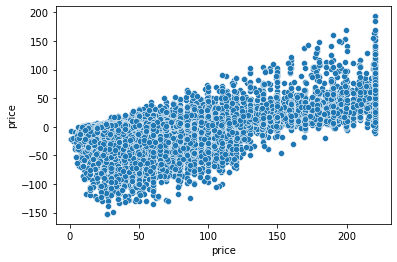

In [163]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [164]:
#Finding r2, mse and rmse using cross validation
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=xgb,X=x,y=y,scoring = 'r2',cv=kf)
r2_xgb = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_xgb = 1 - ((1-r2_xgb)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=xgb,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_xgb = np.abs(np.mean(mse))
rmse_xgb = np.sqrt(mse_xgb)
print(r2_xgb)
print(adj_r2_xgb)
print(rmse_xgb) 

0.7564570240208163
0.7564450065837558
29.751947663328288


In [165]:
# It did improved upon adaboost but fell short of random forest

In [166]:
# Let's see which models we can use for stacking model
results = pd.DataFrame({'Models':['Linear Regression','Decision Tree','Random Forest','AdaBoosting','XGBoosting'],
                        'R-Squared':[r2_lr,r2_dt,r2_rf,r2_ada,r2_xgb],
                        'Adj. R-Squared':[adj_r2_lr,adj_r2_dt,adj_r2_rf,adj_r2_ada,adj_r2_xgb],
                        'MSE':[mse_lr,mse_dt,mse_rf,mse_ada,mse_xgb],
                        'RMSE':[rmse_lr,rmse_dt,rmse_rf,rmse_ada,rmse_xgb]})
results.sort_values(by='RMSE')

,Models,R-Squared,Adj. R-Squared,MSE,RMSE
4,XGBoosting,0.756457,0.756445,885.178390,29.751948
2,Random Forest,0.846930,0.846922,928.503706,30.471359
3,AdaBoosting,0.521605,0.521582,1370.823591,37.024635
0,Linear Regression,0.504272,0.504248,1465.499323,38.281841
1,Decision Tree,0.788448,0.788444,1485.891495,38.547263


In [167]:
# The clear winner is random forest in all cases
# Eventhough r-squared is low for xgb and adaboost we are not concerned about r2 score 
# We need accurate predictions so we are considering rmse as the indicator for performance
# Hence we are choosing xgboost and adaboost along with random forest for stacking model

In [168]:
# Model6 - StackingRegressor
ada = AdaBoostRegressor()
xgb = XGBRegressor(verbosity=0)
rf = RandomForestRegressor()
est = [('Xgboost',xgb),('Adaboost',ada)]
stack = StackingRegressor(estimators=est,final_estimator=rf,cv=5)
model_v5 = stack.fit(xtrain,ytrain)
ypred = model_v5.predict(xtest)

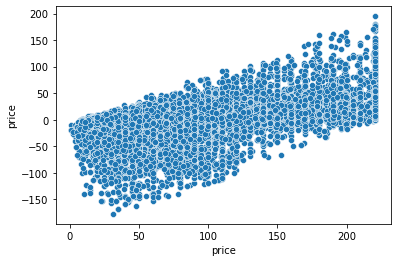

In [169]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [170]:
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=stack,X=x,y=y,scoring = 'r2',cv=kf)
r2_stack = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_stack = 1 - ((1-r2_stack)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=stack,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_stack = np.abs(np.mean(mse))
rmse_stack = np.sqrt(mse_stack)
print(r2_stack)
print(adj_r2_stack)
print(rmse_stack) 

0.6550450766687222
0.6550280551386898
34.07719995795408


In [171]:
# Model7- Voting Regressor

ada = AdaBoostRegressor()
xgb = XGBRegressor(verbosity=0)
rf = RandomForestRegressor()
est = [('Xgboost',xgb),('Adaboost',ada),('Random Forest',rf)]
vote = VotingRegressor(estimators=est)
model_v6 = vote.fit(xtrain,ytrain)
ypred = model_v6.predict(xtest)

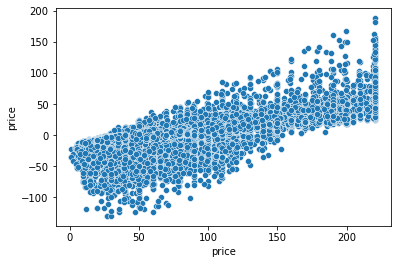

In [172]:
r = ytest-ypred
sns.scatterplot(x = ytest,y = r)
plt.show()

In [173]:
kf= KFold(n_splits=5,shuffle=True,random_state=7)
r2 = cross_val_score(estimator=vote,X=x,y=y,scoring = 'r2',cv=kf)
r2_vote = np.mean(r2)
n = x.shape[0]
k = x.shape[1]
adj_r2_vote = 1 - ((1-r2_vote)*(n-1)/(n-k-1))
mse  = cross_val_score(estimator=vote,X=x,y=y,scoring = 'neg_mean_squared_error',cv=k)
mse_vote = np.abs(np.mean(mse))
rmse_vote = np.sqrt(mse_vote)
print(r2_vote)
print(adj_r2_vote)
print(rmse_vote) 

0.7775585363993482
0.7775475601998594
30.04274143303517


In [174]:
# Final Results
final_res = pd.DataFrame({'Models':['Linear Regression','Decision Tree','Random Forest','AdaBoosting',
                                  'XGBoosting','Stacking Regressor','Voting Regressor'],
                        'R-Squared':[r2_lr,r2_dt,r2_rf,r2_ada,r2_xgb,r2_stack,r2_vote],
                        'Adj. R-Squared':[adj_r2_lr,adj_r2_dt,adj_r2_rf,adj_r2_ada,adj_r2_xgb,adj_r2_stack,
                                          adj_r2_vote],
                        'MSE':[mse_lr,mse_dt,mse_rf,mse_ada,mse_xgb,mse_stack,mse_vote],
                        'RMSE':[rmse_lr,rmse_dt,rmse_rf,rmse_ada,rmse_xgb,rmse_stack,rmse_vote]})
final_res.sort_values(by='RMSE')

,Models,R-Squared,Adj. R-Squared,MSE,RMSE
4,XGBoosting,0.756457,0.756445,885.178390,29.751948
6,Voting Regressor,0.777559,0.777548,902.566313,30.042741
2,Random Forest,0.846930,0.846922,928.503706,30.471359
5,Stacking Regressor,0.655045,0.655028,1161.255557,34.077200
3,AdaBoosting,0.521605,0.521582,1370.823591,37.024635
0,Linear Regression,0.504272,0.504248,1465.499323,38.281841
1,Decision Tree,0.788448,0.788444,1485.891495,38.547263


In [175]:
# We can clearly see random forest is miles ahead of other models
# Hence we are taking random forest as the final model 


In [184]:
# Conclusion
# Random Forest model is better at r-squared and adj r-squared but since xgboost is showing better mse 
# and rmse results we are going forward with xgboost